# Importing Julia packages

In [12]:
using Random
using LightGraphs
using Distributions
using LinearAlgebra

using BenchmarkTools
using PyPlot

## Defining network size and configuration

In [13]:
const N = 200;       # network size

In [14]:
Random.seed!(123) # Setting the seed for generating same sequence of random number each time
#d = Normal()
global omega = rand(Cauchy(0.0,0.5), N) #### gaussian 
#global A = ones(N,N)-Matrix(I,N,N); ## adjacency of all-to-all
G=static_scale_free(N,400,2.3)
A1 = adjacency_matrix(G)
A = Matrix(A1)
global deg=degree(G);

In [15]:
using DifferentialEquations

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = ErrorException("Required dependency Optim [429524aa-4258-5aef-a3af-852621145aeb] failed to load from a cache file.")
└ @ Base loading.jl:1132


## Declaring functions which define the system of Kuramoto equations

In [16]:
# ==========================================
# CPU multiplication
# ==========================================

function kuramoto(du, u, p, t)
    
    u1 = @view u[1:N]
    du1 = @view du[1:N]

    z1 = Array{Complex{Float64},1}(undef, N)
    mul!(z1, A, exp.((u1)im))
    z1 = z1 ./ deg

    @. du1  = omega + p * abs(omega) * imag(z1 * exp((-1im) * u1))
    
    end;

## Setting up initial conditions

In [17]:
# Initial conditions

u0 = rand(N)*2*pi
du = similar(u0);

## Performing benchmark tests

In [18]:
# complex Kuramoto matrix multiplication
@benchmark kuramoto(du, u0, 0.0, 0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   91.654 μs …  2.576 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     101.416 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   119.160 μs ± 68.138 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ██▆▆▄▃▃▃▂▂▃▄▃▂▂▂▁▁▁ ▁▁                                      ▂
  ████████████████████████████▇█▇█▇▇▇▆▆▇▇▇▆▆▅▅▆▆▆▆▆▁▅▆▆▃▆▅▄▅▄▅ █
  91.7 μs       Histogram: log(frequency) by time       326 μs <

 Memory estimate: 13.91 KiB, allocs estimate: 19.

# Performing test calculations

In [19]:
# setting up time steps and integration intervals

dt = 0.01 # time step
dts = 0.1 # save time
ti = 0.0
tt = 500.0 
tf = 1000.0
nt = Int(div(tt,dts))
nf = Int(div(tf,dts))

tspan = (ti, tf); # time interval

In [20]:
λ = collect(1.5:0.02:4.0)

r_fwd = zeros(size(λ)[1])
r_bwd = zeros(size(λ)[1])

println("#####################")
println("Forward transition!")
println("#####################")

for l in 1:size(λ)[1]
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
    r_fwd[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end;

println("#####################")
println("Backward transition!")
println("#####################")

for l in size(λ)[1]:-1:1
    print("λ=")
    println(λ[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto, u0, tspan, λ[l])

    # solving problem using a proper solver
    sol = solve(prob, RK4(), dt=dt, saveat=dts, progress=true);
    r_bwd[l] = mean(abs.(mean(exp.(sol*1im),dims=1)[1,:])[nt:nf]);
    
    u0 = mod2pi.(sol[:,nf])
    end;

#####################
Forward transition!
#####################
λ=1.5


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/aryanpatel/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:523


LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [4999:9999]

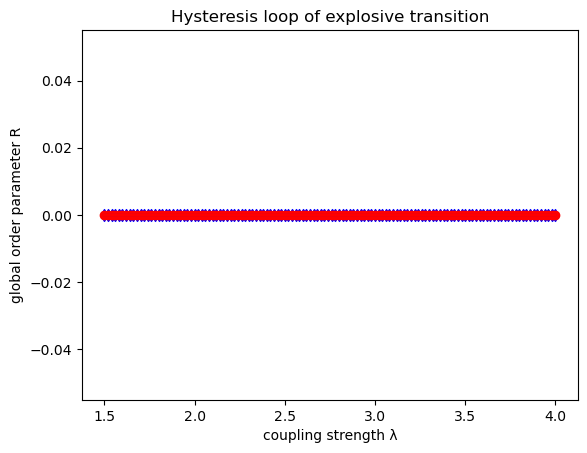

In [21]:
title("Hysteresis loop of explosive transition")
plot(λ,r_fwd,c="blue")
scatter(λ,r_fwd,c="blue",marker="d")
plot(λ,r_bwd,c="red")
scatter(λ,r_bwd,c="red")
ylabel("global order parameter R")
xlabel("coupling strength λ")
show()

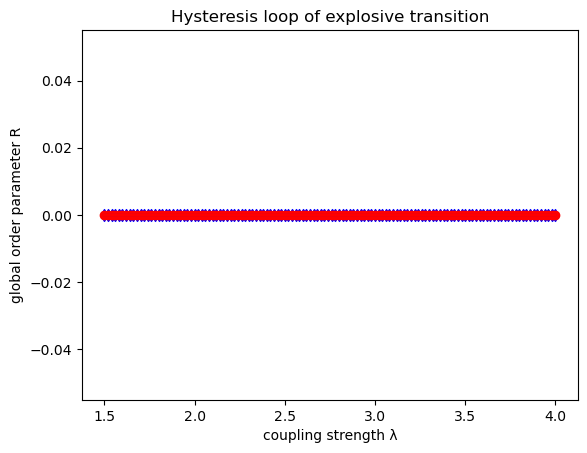

In [22]:
title("Hysteresis loop of explosive transition")
plot(λ,r_fwd,c="blue")
scatter(λ,r_fwd,c="blue",marker="d")
plot(λ,r_bwd,c="red")
scatter(λ,r_bwd,c="red")
ylabel("global order parameter R")
xlabel("coupling strength λ")
show()